### The objective

create a short and sweet notebook that takes in EEGLAB preprocessed data, and outputs SW statistics

## Some questions to look into with time

- why some sw seem to be detected by multiple channels while other sw are detected by a single ch?
- how can we look at "traveling" vs focal sw? i.e Type I vs Type II
- is there specific sw features that are correlated with their distribution?

- are there more sw detected in frontal ch?

In [55]:
#Make sure you have eeglabio for saving the Epochs
#pip install eeglabio


# Housekeeping imports
import mne
from mne.io import RawArray
import numpy as np
import pandas as pd
import yasa
import matplotlib.pyplot as plt  # Make sure to import pyplot as plt for plotting
import statsmodels.api as sm
import ipywidgets as widgets  # Renamed for clarity

# Activate interactive figures with %matplotlib qt (useful in Jupyter environments)
%matplotlib qt


### Load data
* Change the io.methodX based on the EEG file type you are trying to load
* `preload` lets you keep the data in memory and manipulate it in different cells.

In [2]:
fname = '/Users/idohaber/Desktop/Paper_dir/Source_test/1_Functional_Data/0.5-6_full_NREM.set'
raw = mne.io.read_raw_eeglab(fname, preload=True);
#raw.filter(0.5, 30, fir_design='firwin')  # Adjust the frequency range as needed
raw

Reading /Users/idohaber/Desktop/Paper_dir/Source_test/1_Functional_Data/0.5-6_full_NREM.fdt
Reading 0 ... 5369842  =      0.000 ... 10739.684 secs...


/var/folders/0y/xvbtt0c135x04tpfn8c89v300000gn/T/ipykernel_3165/1457560134.py:2: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(fname, preload=True);
/var/folders/0y/xvbtt0c135x04tpfn8c89v300000gn/T/ipykernel_3165/1457560134.py:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(fname, preload=True);


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,197 points
Good channels,194 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [3]:
# prepare the data for processing
data = raw.get_data(units="uV") 
raw.resample(100)
sf = raw.info['sfreq']
print(data.shape , sf)

(194, 5369843) 100.0


In [4]:
events = mne.events_from_annotations(raw)  # raw events
events_id = events[-1]                     # grab event dict
actual_events = events[:-1][0]             # grab actual events
print(events_id, '\n') 
print(actual_events)

Used Annotations descriptions: ['Sleep Stage', 'boundary', 'stim end', 'stim start']
{'Sleep Stage': 1, 'boundary': 2, 'stim end': 3, 'stim start': 4} 

[[      0       0       2]
 [    511       0       1]
 [   3511       0       1]
 ...
 [1068613       0       1]
 [1071613       0       1]
 [1073968       0       2]]


In [51]:
# Assuming you already have `raw` and sampling frequency `sf`

# Extract events and event IDs from annotations in the raw data
events, event_id = mne.events_from_annotations(raw)  # raw events

print(event_id, '\n')
print(events)

# Dictionary mapping event descriptions to numerical codes
column_dict = {'Sleep Stage': 1, 'boundary': 2, 'stim end': 3, 'stim start': 4}

# Indices for 'stim end' and 'stim start'
stim_end_index = column_dict['stim end']
stim_start_index = column_dict['stim start']

# Filter events to get only stim start and stim end
filtered_data = [item for item in events if item[2] == stim_end_index or item[2] == stim_start_index]

# Minimum stim duration threshold in seconds (example: 100 seconds)
min_stim_duration_sec = 100
min_stim_duration_samples = int(min_stim_duration_sec * sf)

# Initialize lists for pre-stim, early stim, late stim, and post-stim epochs with protocol numbers
pre_stim_epochs = []
early_stim_epochs = []
late_stim_epochs = []
post_stim_epochs = []

# Previous epoch end to check for overlap
previous_end = 0

# Protocol counter
protocol_number = 1

# Loop through the epochs and define pre-stim, early stim, late stim, and post-stim epochs
for i in range(0, len(filtered_data), 2):
    if i + 1 < len(filtered_data):  # Ensure i+1 is within bounds
        stim_start = filtered_data[i][0]
        stim_end = filtered_data[i+1][0]
        stim_duration = stim_end - stim_start  # Calculate stim duration
        
        if stim_duration < min_stim_duration_samples:
            continue  # Skip this stim epoch if it is shorter than the minimum duration
        
        stim_midpoint = (stim_start + stim_end) // 2  # Calculate the midpoint of the stim epoch
        
        pre_stim_epoch = (stim_start - stim_duration, stim_start, protocol_number)
        early_stim_epoch = (stim_start, stim_midpoint, protocol_number)
        late_stim_epoch = (stim_midpoint, stim_end, protocol_number)
        post_stim_epoch = (stim_end, stim_end + stim_duration, protocol_number)
        
        # Check for overlap with the previous epoch
        if pre_stim_epoch[0] < previous_end:
            continue  # Skip this entire protocol if there's an overlap with the previous one
        
        # Update previous_end to the end of the current post-stim epoch
        previous_end = post_stim_epoch[1]
        
        pre_stim_epochs.append(pre_stim_epoch)
        early_stim_epochs.append(early_stim_epoch)
        late_stim_epochs.append(late_stim_epoch)
        post_stim_epochs.append(post_stim_epoch)
        
        # Increment protocol number
        protocol_number += 1

# Convert epochs to time for plotting
def convert_sample_to_time(epochs, sf):
    return [(start / sf, end / sf) for start, end, protocol in epochs]

pre_stim_epochs_time = convert_sample_to_time(pre_stim_epochs, sf)
early_stim_epochs_time = convert_sample_to_time(early_stim_epochs, sf)
late_stim_epochs_time = convert_sample_to_time(late_stim_epochs, sf)
post_stim_epochs_time = convert_sample_to_time(post_stim_epochs, sf)

# Optionally store or print protocol numbers for reference
protocol_numbers = [epoch[2] for epoch in pre_stim_epochs]  # Collect protocol numbers (only need to do it once)
print(f"Protocol Numbers: {protocol_numbers}")

# Plotting
plt.figure(figsize=(10, 6))

# Plot pre-stim epochs as shaded regions
for (start, end) in pre_stim_epochs_time:
    plt.axvspan(start, end, color='blue', alpha=0.3, label='Pre-Stim')

# Plot early stim epochs as shaded regions
for (start, end) in early_stim_epochs_time:
    plt.axvspan(start, end, color='orange', alpha=0.3, label='Early Stim')

# Plot late stim epochs as shaded regions
for (start, end) in late_stim_epochs_time:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Late Stim')

# Plot post-stim epochs as shaded regions
for (start, end) in post_stim_epochs_time:
    plt.axvspan(start, end, color='green', alpha=0.3, label='Post-Stim')

# Set labels and title
plt.xlabel('Time (s)')
plt.ylabel('Epoch Type')
plt.title('Epochs Visualization with Early and Late Stim Splitting')

# To prevent duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


Used Annotations descriptions: ['Sleep Stage', 'boundary', 'stim end', 'stim start']
{'Sleep Stage': 1, 'boundary': 2, 'stim end': 3, 'stim start': 4} 

[[      0       0       2]
 [    511       0       1]
 [   3511       0       1]
 ...
 [1068613       0       1]
 [1071613       0       1]
 [1073968       0       2]]
Protocol Numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [6]:
#sw = yasa.sw_detect(raw, hypno=hypno_up, include=(2, 3))
sw = yasa.sw_detect(raw, verbose=False, coupling=False);
df = sw.summary(); # general summary for each sw
df # Inspect the dataframe

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.8s
25-Aug-24 15:45:34 | WARNING | No SW were found in channel E50.


,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,273.76,274.03,274.86,275.16,275.65,1.89,-41.824487,33.425113,75.249599,90.662168,0.529101,E1,0
1,545.35,545.66,545.90,546.19,546.51,1.16,-40.937927,55.789954,96.727881,403.032836,0.862069,E1,0
2,1209.77,1210.18,1210.51,1210.79,1211.14,1.37,-50.271566,32.988102,83.259668,252.302023,0.729927,E1,0
3,1211.14,1211.49,1211.75,1212.06,1212.71,1.57,-41.000249,47.190866,88.191115,339.196596,0.636943,E1,0
4,1212.71,1213.75,1214.07,1214.41,1214.84,2.13,-48.924268,27.038476,75.962744,237.383574,0.469484,E1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7752,8782.88,8783.18,8783.44,8783.62,8783.85,0.97,-50.691698,25.743016,76.434714,293.979671,1.030928,E253,193
7753,9180.13,9180.50,9180.77,9181.10,9181.55,1.42,-54.312763,79.285652,133.598416,494.808946,0.704225,E253,193
7754,9962.47,9963.12,9963.38,9963.70,9964.08,1.61,-45.219392,69.214942,114.434334,440.132054,0.621118,E253,193
7755,9964.08,9964.53,9965.31,9965.70,9966.23,2.15,-48.162902,68.680883,116.843785,149.799724,0.465116,E253,193


In [ ]:
sw.plot_detection() # lets you scroll through the detection very conveniently

In [7]:
# Define the classification function
def classify_wave(start_time, pre_stim_epochs_time, early_stim_epochs_time, late_stim_epochs_time, post_stim_epochs_time):
    """Classify each wave based on the start time into 'Pre-Stim', 'Early-Stim', 'Late-Stim', or 'Post-Stim' and assign protocol number."""
    for idx, (start, end) in enumerate(pre_stim_epochs_time):
        if start <= start_time <= end:
            return 'Pre-Stim', idx + 1
    for idx, (start, end) in enumerate(early_stim_epochs_time):
        if start <= start_time <= end:
            return 'Early-Stim', idx + 1
    for idx, (start, end) in enumerate(late_stim_epochs_time):
        if start <= start_time <= end:
            return 'Late-Stim', idx + 1
        
    for idx, (start, end) in enumerate(post_stim_epochs_time):
        if start <= start_time <= end:
            return 'Post-Stim', idx + 1
    return 'Unknown', None  # If the wave does not fall within any of the epochs

# Apply classification to DataFrame
df[['Classification', 'Protocol Number']] = df['Start'].apply(lambda start_time: classify_wave(start_time, pre_stim_epochs_time, early_stim_epochs_time, late_stim_epochs_time, post_stim_epochs_time)).apply(pd.Series)

# Filter out rows classified as 'Unknown'
df_filtered = df[df['Classification'] != 'Unknown']

# Now df_filtered contains both the classification and the protocol number for each wave.


In [8]:

# Group by classification and calculate mean and count for each group
comparison_means = df_filtered.groupby('Classification')[['Duration', 'ValNegPeak', 'ValPosPeak', 'PTP', 'Frequency']].mean()
comparison_counts = df_filtered.groupby('Classification')['Start'].count()  # Counting instances using the 'Start' column

# Print results
print("Mean Values by Group:")
print(comparison_means)
print("\nCount of Instances by Group:")
print(comparison_counts)


Mean Values by Group:
                Duration  ValNegPeak  ValPosPeak         PTP  Frequency
Classification                                                         
Early-Stim      1.557771  -54.866958   49.426493  104.293451   0.666882
Late-Stim       1.594121  -54.061757   50.527821  104.589577   0.657163
Post-Stim       1.464050  -53.450962   46.468855   99.919817   0.718585
Pre-Stim        1.496005  -52.440277   46.623603   99.063881   0.700583

Count of Instances by Group:
Classification
Early-Stim     933
Late-Stim     1109
Post-Stim     2020
Pre-Stim      1457
Name: Start, dtype: int64


In [18]:
df #look at the frame to make sure classification added properly 

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel,Classification,Protocol Number
0,273.76,274.03,274.86,275.16,275.65,1.89,-41.824487,33.425113,75.249599,90.662168,0.529101,E1,0,Early-Stim,1.0
1,545.35,545.66,545.90,546.19,546.51,1.16,-40.937927,55.789954,96.727881,403.032836,0.862069,E1,0,Post-Stim,1.0
2,1209.77,1210.18,1210.51,1210.79,1211.14,1.37,-50.271566,32.988102,83.259668,252.302023,0.729927,E1,0,Post-Stim,2.0
3,1211.14,1211.49,1211.75,1212.06,1212.71,1.57,-41.000249,47.190866,88.191115,339.196596,0.636943,E1,0,Post-Stim,2.0
4,1212.71,1213.75,1214.07,1214.41,1214.84,2.13,-48.924268,27.038476,75.962744,237.383574,0.469484,E1,0,Post-Stim,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7752,8782.88,8783.18,8783.44,8783.62,8783.85,0.97,-50.691698,25.743016,76.434714,293.979671,1.030928,E253,193,Unknown,NaN
7753,9180.13,9180.50,9180.77,9181.10,9181.55,1.42,-54.312763,79.285652,133.598416,494.808946,0.704225,E253,193,Early-Stim,12.0
7754,9962.47,9963.12,9963.38,9963.70,9964.08,1.61,-45.219392,69.214942,114.434334,440.132054,0.621118,E253,193,Unknown,NaN
7755,9964.08,9964.53,9965.31,9965.70,9966.23,2.15,-48.162902,68.680883,116.843785,149.799724,0.465116,E253,193,Unknown,NaN


In [52]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart."""
    for rect in ax.patches:
        # Get the height of each bar
        height = rect.get_height()
        # Adding text annotation on the bar
        ax.text(
            rect.get_x() + rect.get_width() / 2,  # X coordinate of the text
            height + spacing,  # Y coordinate of the text (with some spacing)
            f'{height:.2f}',  # Format the label as needed
            ha='center',  # Horizontal alignment
            va='bottom'  # Vertical alignment
        )

plt.figure(figsize=(15, 6))

# Plotting Mean Values with annotations and moving the legend outside
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
ax = comparison_means.plot(kind='bar', ax=plt.gca(), color=['#6baed6', '#bdd7e7', '#eff3ff', '#fdbe85', '#fd8d3c'])
plt.title('Mean Values of Wave Properties')
plt.ylabel('Mean Values')
plt.xlabel('Classification', labelpad=10)
plt.xticks(rotation=0)
add_value_labels(ax)  # Adding the value labels
plt.legend(title='Properties', loc='upper left', bbox_to_anchor=(1, 1))  # Moving the legend outside

# Plotting Counts with annotations and moving the legend outside
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
ax2 = comparison_counts.plot(kind='bar', color='#6baed6', ax=plt.gca())
plt.title('Count of Instances by Group')
plt.ylabel('Count')
plt.xlabel('Classification', labelpad=10)
plt.xticks(rotation=0)
add_value_labels(ax2)  # Adding the value labels

# Show plots
plt.tight_layout()  # Adjust subplots to give some padding and prevent overlap
plt.show()


In [53]:
# Assuming df is your original DataFrame with relevant columns

# Define the specific columns you want to plot
columns_to_plot = ['Duration', 'ValNegPeak', 'ValPosPeak', 'PTP', 'Frequency']

# Define all possible classifications except 'Unknown'
all_classifications = ['Early-Stim', 'Post-Stim', 'Pre-Stim', 'Late-Stim']

# Filter out 'Unknown' classification from the DataFrame
df_filtered = df[df['Classification'].isin(all_classifications)]

# Calculate overall means and counts, including all classifications except 'Unknown'
overall_means = df_filtered.groupby('Classification')[columns_to_plot].mean().reindex(all_classifications, fill_value=0)
overall_counts = df_filtered['Classification'].value_counts().reindex(all_classifications, fill_value=0)

# Function to add value labels on bars
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart."""
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        label = f"{y_value:.2f}" if y_value != 0 else "0"  # Use a single zero for labels with no decimal part
        ax.annotate(
            label, 
            (x_value, y_value), 
            xytext=(0, spacing), 
            textcoords="offset points", 
            ha='center', 
            va='bottom'
        )

# Figure 1: Overall comparison for all classifications combined, disregarding protocol number
plt.figure(figsize=(15, 6))

# Overall Mean Values Plot
plt.subplot(1, 2, 1)
ax = overall_means.plot(kind='bar', ax=plt.gca(), color=['#6baed6', '#bdd7e7', '#eff3ff', '#fdbe85', '#fd8d3c'])
plt.title('Overall Mean Values of Wave Properties (All Protocols Combined)')
plt.ylabel('Mean Values')
plt.xlabel('Classification', labelpad=10)
plt.xticks(rotation=0)
plt.legend(title='Properties', loc='upper left', bbox_to_anchor=(1, 1))  # Moving the legend outside
add_value_labels(ax)  # Add value labels

# Overall Count Plot
plt.subplot(1, 2, 2)
ax2 = overall_counts.plot(kind='bar', color='#6baed6', ax=plt.gca())
plt.title('Overall Count of Instances by Classification (All Protocols Combined)')
plt.ylabel('Count')
plt.xlabel('Classification', labelpad=10)
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Moving the legend outside
add_value_labels(ax2)  # Add value labels

# Show the overall plot
plt.tight_layout()  # Adjusts subplots to give some padding and prevent overlap
plt.show()

# Now, let's create separate plots for each protocol
protocol_numbers = df_filtered['Protocol Number'].dropna().unique()  # Get unique protocol numbers

for protocol in protocol_numbers:
    protocol_data = df_filtered[df_filtered['Protocol Number'] == protocol]
    protocol_means = protocol_data.groupby('Classification')[columns_to_plot].mean().reindex(all_classifications, fill_value=0)
    protocol_counts = protocol_data['Classification'].value_counts().reindex(all_classifications, fill_value=0)

    plt.figure(figsize=(15, 6))

    # Mean values for each protocol
    plt.subplot(1, 2, 1)
    ax = protocol_means.plot(kind='bar', ax=plt.gca(), color=['#6baed6', '#bdd7e7', '#eff3ff', '#fdbe85', '#fd8d3c'])
    plt.title(f'Mean Values of Wave Properties (Protocol {protocol})')
    plt.ylabel('Mean Values')
    plt.xlabel('Classification', labelpad=10)
    plt.xticks(rotation=0)
    plt.legend(title='Properties', loc='upper left', bbox_to_anchor=(1, 1))  # Moving the legend outside
    add_value_labels(ax)  # Add value labels

    # Counts for each protocol
    plt.subplot(1, 2, 2)
    ax2 = protocol_counts.plot(kind='bar', color='#6baed6', ax=plt.gca())
    plt.title(f'Count of Instances by Classification (Protocol {protocol})')
    plt.ylabel('Count')
    plt.xlabel('Classification', labelpad=10)
    plt.xticks(rotation=0)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Moving the legend outside
    add_value_labels(ax2)  # Add value labels

    # Show the plots for this protocol
    plt.tight_layout()
    plt.show()


In [20]:
# Assuming 'df' is your DataFrame
# Filter out rows where 'Protocol Number' is NaN
df_filtered = df.dropna(subset=['Protocol Number'])

# Generate the slow wave names
df_filtered['Slow_Wave_Name'] = 'proto' + df_filtered['Protocol Number'].astype(int).astype(str) + '_' + df_filtered['Classification'].str.lower().replace(' ', '-') + '_sw' + (df_filtered.groupby(['Protocol Number', 'Classification']).cumcount() + 1).astype(str)

# Define the order for the 'Classification'
classification_order = ['pre-stim', 'early-stim', 'late-stim', 'post-stim']

# Create a categorical type for sorting Classification
df_filtered['Classification'] = df_filtered['Classification'].str.lower().replace(' ', '-')
df_filtered['Classification'] = pd.Categorical(df_filtered['Classification'], categories=classification_order, ordered=True)

# Sort the DataFrame based on Protocol Number, Classification order, and slow wave number (extracted from Slow_Wave_Name)
df_sorted = df_filtered.sort_values(by=['Protocol Number', 'Classification', 'Slow_Wave_Name'])

# Keep only the relevant columns
df_epochs = df_sorted[['Slow_Wave_Name', 'Start', 'End', 'Protocol Number', 'Classification']]

# Display the DataFrame with the new columns
print(df_epochs.head())

# Save the resulting DataFrame to a CSV file
df_epochs.to_csv('sorted_slow_waves.csv', index=False)


           Slow_Wave_Name   Start     End  Protocol Number Classification
149   proto1_pre-stim_sw1  168.91  169.98              1.0       pre-stim
516  proto1_pre-stim_sw10  162.20  163.75              1.0       pre-stim
696  proto1_pre-stim_sw11  168.89  169.99              1.0       pre-stim
832  proto1_pre-stim_sw12  168.92  169.88              1.0       pre-stim
833  proto1_pre-stim_sw13  199.70  201.33              1.0       pre-stim


/var/folders/0y/xvbtt0c135x04tpfn8c89v300000gn/T/ipykernel_3165/494115863.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Slow_Wave_Name'] = 'proto' + df_filtered['Protocol Number'].astype(int).astype(str) + '_' + df_filtered['Classification'].str.lower().replace(' ', '-') + '_sw' + (df_filtered.groupby(['Protocol Number', 'Classification']).cumcount() + 1).astype(str)
/var/folders/0y/xvbtt0c135x04tpfn8c89v300000gn/T/ipykernel_3165/494115863.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [22]:
# Assuming df_epochs is your sorted DataFrame from the previous steps
# Initialize a list to collect the filtered epochs
filtered_epochs_list = []

# Initialize a variable to keep track of the last valid end time
last_end_time = -float('inf')

# Iterate over the sorted DataFrame
for index, row in df_epochs.iterrows():
    if row['Start'] > last_end_time + 0.5:
        # Add the row to the list if it doesn't overlap within 0.5s of the previous
        filtered_epochs_list.append(row)
        # Update the last_end_time to the current row's end time
        last_end_time = row['End']

# Convert the list of filtered epochs to a DataFrame
filtered_epochs = pd.DataFrame(filtered_epochs_list, columns=df_epochs.columns)

# Display the filtered DataFrame
print(filtered_epochs.head())

# Save the filtered DataFrame to a CSV if needed
filtered_epochs.to_csv('filtered_epochs.csv', index=False)


             Slow_Wave_Name   Start     End  Protocol Number Classification
149     proto1_pre-stim_sw1  168.91  169.98              1.0       pre-stim
833    proto1_pre-stim_sw13  199.70  201.33              1.0       pre-stim
834    proto1_pre-stim_sw14  203.04  204.59              1.0       pre-stim
0     proto1_early-stim_sw1  273.76  275.65              1.0     early-stim
698  proto1_early-stim_sw11  281.11  282.08              1.0     early-stim


In [28]:
# Assuming `filtered_epochs` is your filtered DataFrame and `raw` is your MNE Raw object
# Also assuming `sf` is the sampling frequency of your data

# Convert 'Start' and 'End' times to sample indices
start_samples = (filtered_epochs['Start'] * sf).astype(int)
end_samples = (filtered_epochs['End'] * sf).astype(int)

# Add 0.2 seconds before the start of each epoch for the baseline
baseline_samples = int(0.2 * sf)
new_start_samples = start_samples - baseline_samples

# Ensure that new start times are not negative
new_start_samples[new_start_samples < 0] = 0

# Set tmin to -0.2 to include the baseline period, and tmax to the end of the longest epoch relative to the new start
tmin = -0.2
tmax = (end_samples - new_start_samples).max() / sf

# Create an events array using the updated start times
events = np.column_stack((new_start_samples, np.zeros_like(new_start_samples), np.ones_like(new_start_samples)))

# Create epochs with the extended time window and apply baseline correction
epochs = mne.Epochs(raw, events, event_id=1, tmin=tmin, tmax=tmax, baseline=(tmin, 0), preload=True)

# Plotting the epochs
epochs.plot(scalings={'eeg': 60e-6})  # Adjust scalings if necessary

# Plotting epochs with the image plot that includes the average and the individual epochs
epochs.plot_image(combine='mean')

Not setting metadata
148 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 148 events and 288 original time points ...
0 bad epochs dropped
Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


[<Figure size 1280x960 with 3 Axes>]

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [44]:


# Load the CSV file
filtered_epochs = pd.read_csv('filtered_epochs.csv')

# Assuming `raw` is your MNE Raw object, and `sf` is the sampling frequency
sf = raw.info['sfreq']
baseline_duration = 0.2  # Duration of the baseline in seconds

# Loop through each row in the DataFrame
for index, row in filtered_epochs.iterrows():
    # Calculate start and end sample indices
    start_sample = int((row['Start'] - baseline_duration) * sf)
    end_sample = int(row['End'] * sf)
    
    # Ensure start_sample is not less than 0
    if start_sample < 0:
        start_sample = 0
    
    # Extract the data for this epoch, including the baseline
    epoch_data = raw.get_data(start=start_sample, stop=end_sample)
    
    # Create a new RawArray for the single epoch
    info = raw.info.copy()  # Copy the info to maintain consistency
    single_epoch = RawArray(epoch_data, info)
    
    # Define the filename based on Slow_Wave_Name
    filename = f"{row['Slow_Wave_Name']}.set"
    
    # Save the epoch as a .set file
    mne.export.export_raw(fname=filename, raw=single_epoch, fmt='eeglab')


Creating RawArray with float64 data, n_channels=194, n_times=127
    Range : 0 ... 126 =      0.000 ...     1.260 secs
Ready.
Creating RawArray with float64 data, n_channels=194, n_times=183
    Range : 0 ... 182 =      0.000 ...     1.820 secs
Ready.
Creating RawArray with float64 data, n_channels=194, n_times=175
    Range : 0 ... 174 =      0.000 ...     1.740 secs
Ready.
Creating RawArray with float64 data, n_channels=194, n_times=208
    Range : 0 ... 207 =      0.000 ...     2.070 secs
Ready.
Creating RawArray with float64 data, n_channels=194, n_times=117
    Range : 0 ... 116 =      0.000 ...     1.160 secs
Ready.
Creating RawArray with float64 data, n_channels=194, n_times=126
    Range : 0 ... 125 =      0.000 ...     1.250 secs
Ready.
Creating RawArray with float64 data, n_channels=194, n_times=189
    Range : 0 ... 188 =      0.000 ...     1.880 secs
Ready.
Creating RawArray with float64 data, n_channels=194, n_times=123
    Range : 0 ... 122 =      0.000 ...     1.220 secs

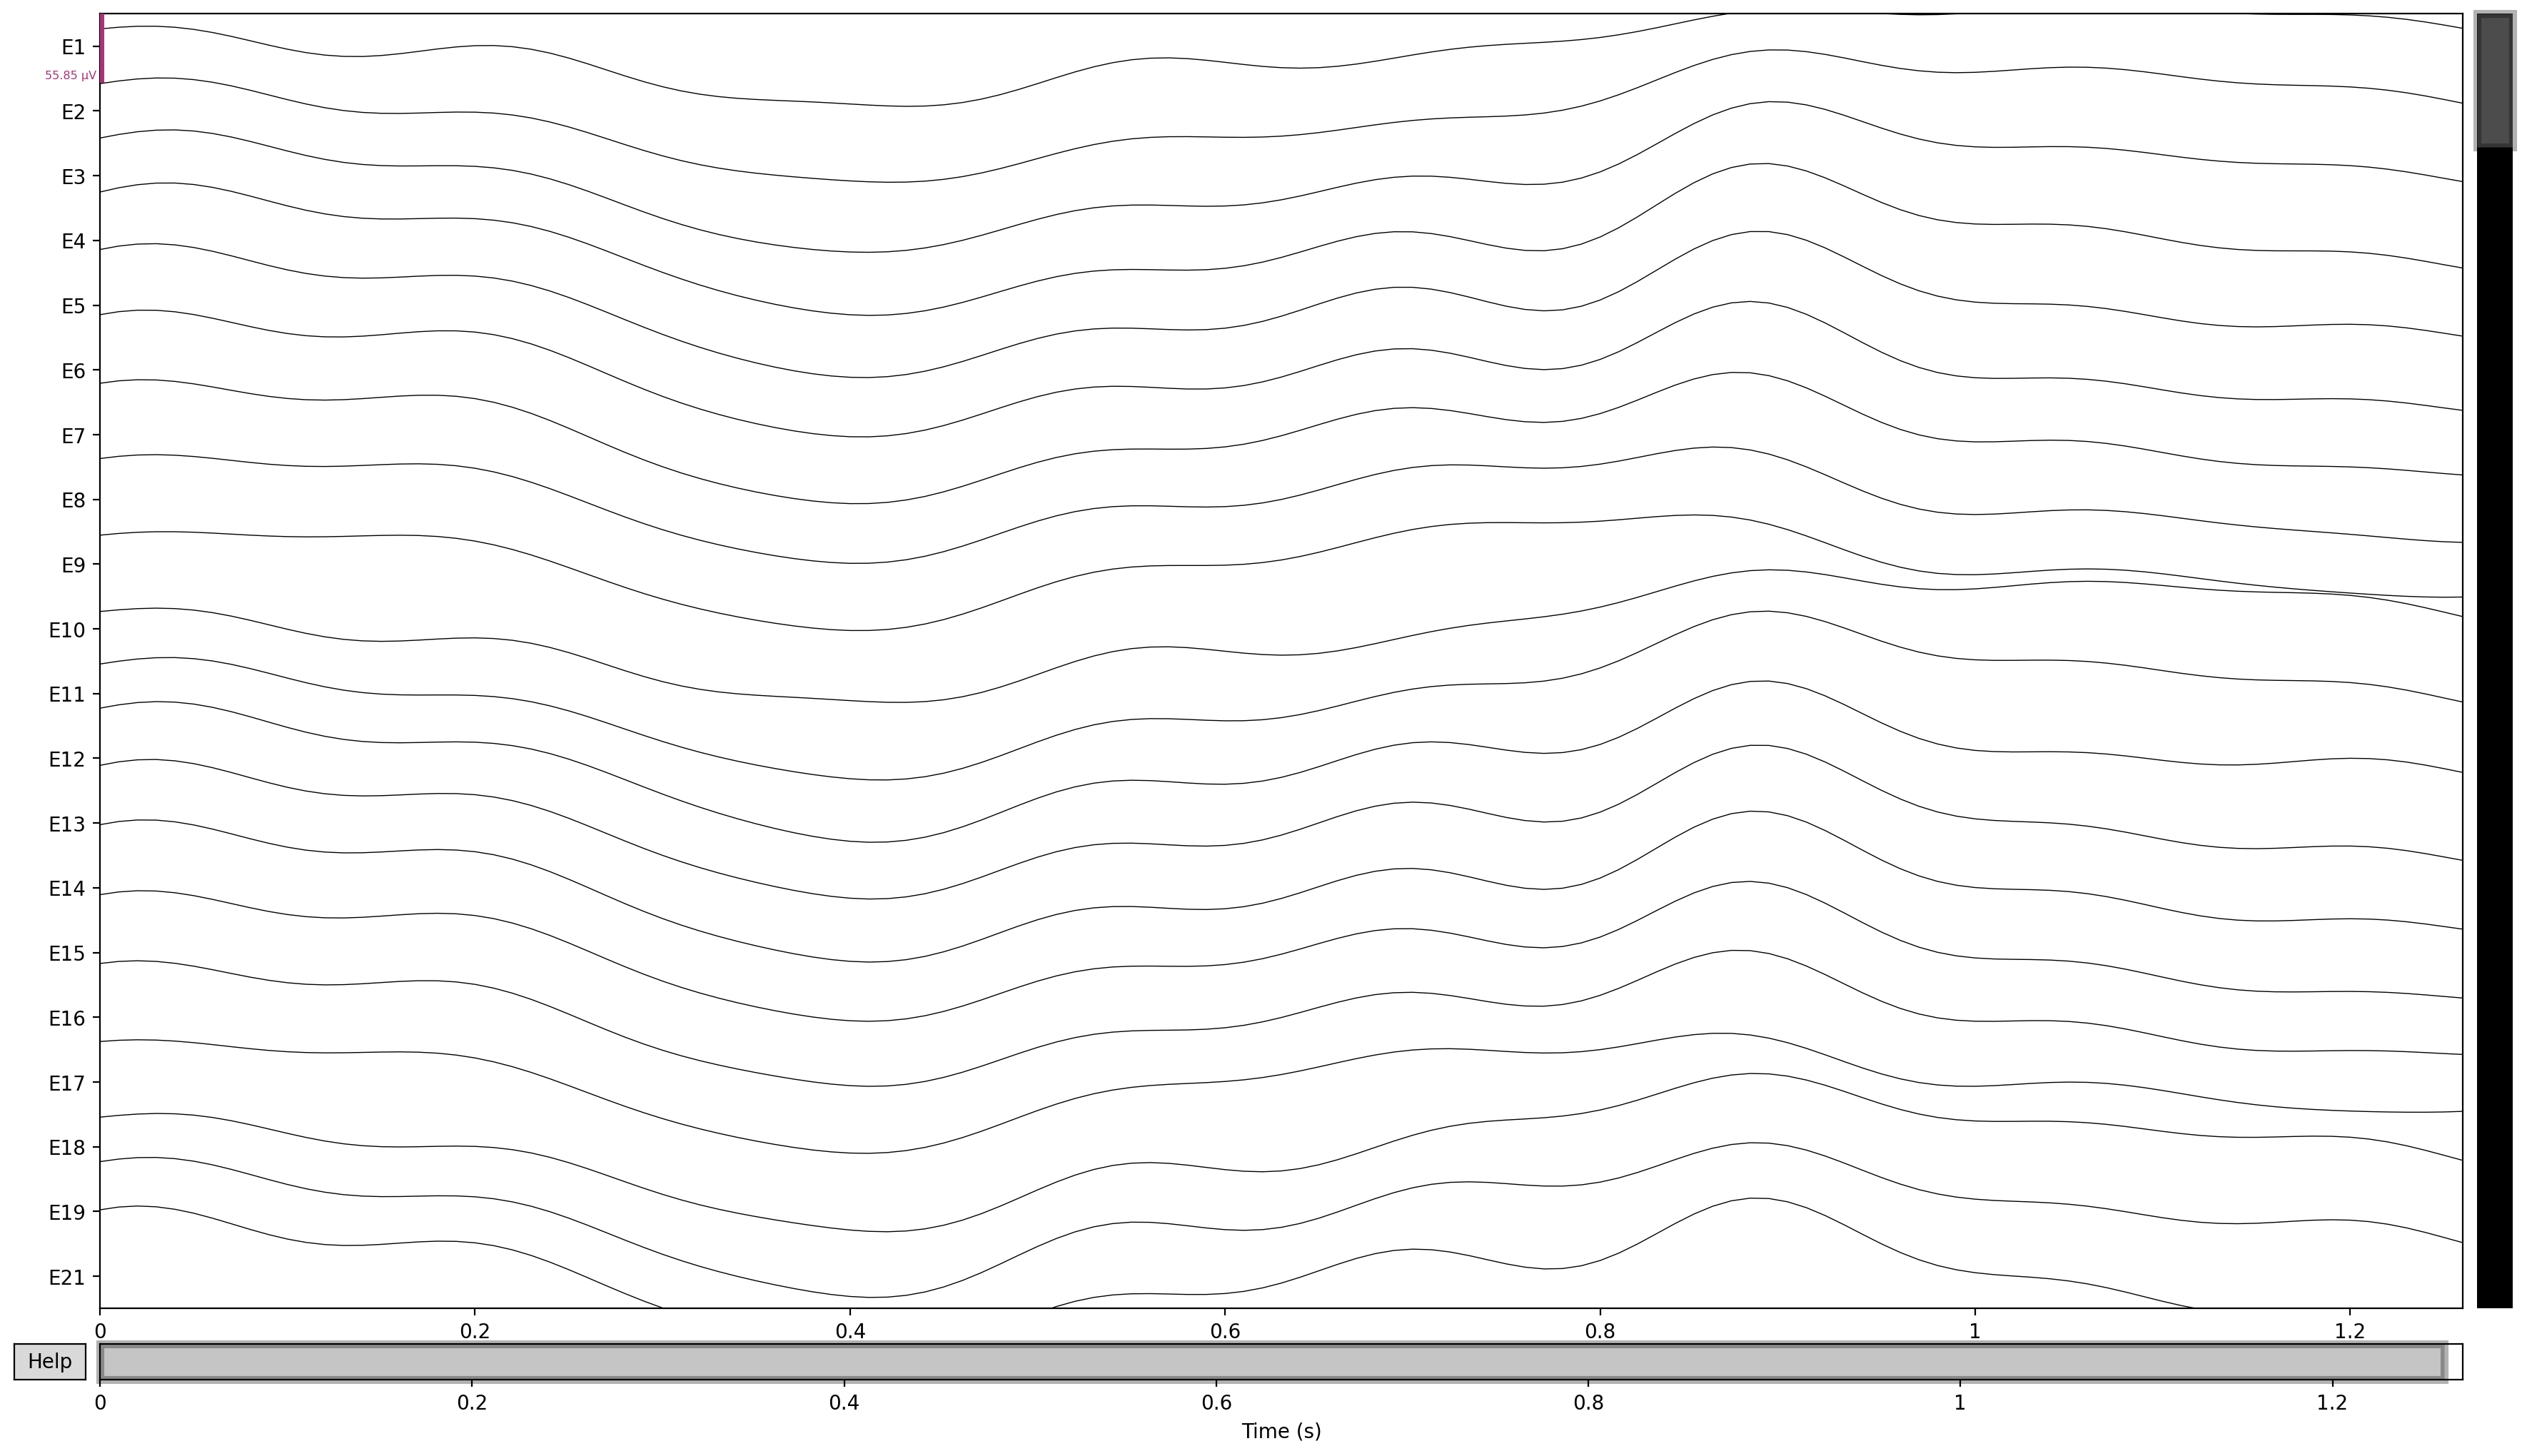

Channels marked as bad:
none


In [49]:
# Load the .set file
filename = 'proto1_pre-stim_sw1.set'  # Replace with the actual filename of the epoch you want to load
raw_epoch = mne.io.read_raw_eeglab(filename, preload=True)

# Plot the raw data
raw_epoch.plot(scalings='auto', show=True)


In [48]:
# Assuming `epochs` is your MNE Epochs object
# Specify the channel name or index you want to plot
channel_name = 'E50'  # Replace 'Cz' with your desired channel name

# Use the `plot_image()` function to plot the mean image for the selected channel
epochs.plot_image(picks=[channel_name], combine='mean')

# You can also plot the image without combining to see individual epochs
# epochs.plot_image(picks=[channel_name])  # Uncomment this line to see individual epochs


Not setting metadata
148 matching events found
No baseline correction applied
0 projection items activated


combining channels using "mean"


/var/folders/0y/xvbtt0c135x04tpfn8c89v300000gn/T/ipykernel_3165/3310972409.py:6: RuntimeWarning: Only one channel in group "E50"; cannot combine by method "mean".
  epochs.plot_image(picks=[channel_name], combine='mean')
/var/folders/0y/xvbtt0c135x04tpfn8c89v300000gn/T/ipykernel_3165/3310972409.py:6: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  epochs.plot_image(picks=[channel_name], combine='mean')


[<Figure size 1280x960 with 3 Axes>]

In [24]:
# Assuming `epochs` is your MNE Epochs object

# Extend the epochs by adding 0.2 seconds only before the start (tmin)
extended_tmin = epochs.tmin - 0.2
extended_tmax = epochs.tmax  # Keep the original tmax

# Create new epochs with the extended time window and apply baseline correction
# Use EpochsArray instead of Epochs
epochs_extended = mne.EpochsArray(epochs.copy().get_data(), info=epochs.info, 
                                  events=epochs.events, event_id=epochs.event_id,
                                  tmin=extended_tmin, baseline=(extended_tmin, 0))

# Define the time points at which you want to plot the topomap
times = np.linspace(epochs_extended.tmin, epochs_extended.tmax, 10)  # 10 evenly spaced time points

# Get the info object from the extended epochs
info = epochs_extended.info

# Iterate over each epoch to plot the topomap
for i, epoch in enumerate(epochs_extended[:2].get_data()):  # Limiting to the first 2 epochs
    for time in times:
        # Find the closest sample to the desired time point
        sample = int((time - epochs_extended.tmin) * epochs_extended.info['sfreq'])

        # Extract the data for that time point
        data = epoch[:, sample]

        # Plot topomap
        mne.viz.plot_topomap(data, info, show=True)


Not setting metadata
142 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


/var/folders/0y/xvbtt0c135x04tpfn8c89v300000gn/T/ipykernel_3165/323204628.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_extended = mne.EpochsArray(epochs.copy().get_data(), info=epochs.info,
/var/folders/0y/xvbtt0c135x04tpfn8c89v300000gn/T/ipykernel_3165/323204628.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for i, epoch in enumerate(epochs_extended[:2].get_data()):  # Limiting to the first 2 epochs


In [ ]:
# Assuming df is your DataFrame name
print("Descriptive Statistics for Start Times:")
print(df['Start'].describe())

print("\nDescriptive Statistics for Slope:")
print(df['Slope'].describe())

correlation = df['Start'].corr(df['Slope'])
print("Correlation coefficient between 'Start' and 'Slope':", correlation)

In [ ]:
# Ensure 'Start' is the independent variable and 'Slope' is the dependent variable
X = sm.add_constant(df['Start'])  # adding a constant
y = df['Slope']
model = sm.OLS(y, X).fit()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['Start'], df['Slope'], alpha=0.5, label='Data Points') #alpha controls the transperacy
plt.plot(df['Start'], model.predict(X), color='red', label='Regression Line')
plt.title('Relationship between Start Time and Slope of Slow Waves')
plt.xlabel('Start Time (s)')
plt.ylabel('Slope')
plt.legend()
plt.show()

In [ ]:
sw_chan = sw.summary(grp_chan=True, grp_stage=True) #summary per channel
sw_chan.head(10)

In [ ]:
raw.plot_sensors(kind='3d', show_names=True ); # this is a place holder for now so I do not forget

### How to create manual epochs for SW and average them
1. raster plot
2. line graph

In [ ]:
channels = ['EEG 001' , 'EEG 002' , 'EEG 003']

# Loop over each channel
for chn in channels:
    # Filter DataFrame for current channel
    df_chn = df[df['Channel'] == chn]
    # Convert 'Start' and 'End' times to sample indices
    start_samples = (df_chn['Start'] * sf).astype(int)
    end_samples = (df_chn['End'] * sf).astype(int)
    # Calculate tmin and tmax
    tmin = -0.2  # 200 ms before the start time
    tmax = np.max((end_samples - start_samples) / sf) + 0.1  # 500 ms after the longest end
    # Create an events array
    events_chn = np.column_stack((start_samples, np.zeros_like(start_samples), np.ones_like(start_samples)))
    # Create Epochs
    epochs_chn = mne.Epochs(raw, events_chn, event_id=1, tmin=tmin, tmax=tmax, picks=[chn], baseline=(None, 0), preload=True)

    # Plotting
    # Plot epochs
    epochs_chn.plot(scalings={'eeg': 60e-6})  # Adjust scalings if necessary

    # Plotting epochs with the image plot that includes the average and the individual epochs
    epochs_chn.plot_image(picks=chn, combine='mean')

    

    

In [ ]:
sw.plot_average(figsize=(12, 9)) # creates an avg figure for all SW from all channels

### Troubleshooting
The following cells will come in handy if you need further data manipulation

In [ ]:
# Find the index of the minimum value in the 'ValNegPeak' column
min_index = df['ValNegPeak'].idxmin()

# To display the index
print("Index of minimum value in 'ValNegPeak':", min_index)

# If you want to see the entire row corresponding to this minimum value
min_value_row = df.loc[min_index]
print(min_value_row)